In [ ]:
date = "20150830"

pcp_path = r"/PCP_cleaned"
eth_path = r"/ETH"

In [ ]:
from collections import Counter
from os import listdir

pcp_files = [file[:-7] for file in listdir(pcp_path)]
pcp_counts = Counter(pcp_files)
sorted_pcp_counts = dict(sorted(pcp_counts.items(), key=lambda item: item[1], reverse=True))
sorted_pcp_counts

In [98]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import re

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

times = [dt.strftime('%H%M') for dt in datetime_range(datetime(2000, 1, 1, 0, 0), datetime(2000, 1, 2, 00, 00), timedelta(minutes=5))]
times = np.array(times)

eth_files = [file for file in listdir(eth_path) if re.search(date, file)]
pcp_files = [file for file in listdir(pcp_path) if re.search(date, file)]

pcp_dataarr = np.full((288, 765, 700), fill_value=np.nan)
pcp_datearr = list()

for i, file in tqdm(enumerate(pcp_files), total=len(pcp_files)):
    with h5py.File(join(pcp_path, file), "r") as f:
        idx = np.where(times == file.split('_')[-1].split('.')[0][-4:])[0][0]
        pcp_dataarr[idx] = f['image1']['image_data'][()]
        pcp_datearr.append(file.split('_')[-1].split('.')[0])

eth_dataarr = np.full((288, 765, 700), fill_value=np.nan)
eth_datearr = list()

for i, file in tqdm(enumerate(eth_files), total=len(eth_files)):
    with h5py.File(join(eth_path, file), "r") as f:
        idx = np.where(times == file.split('_')[-1].split('.')[0][-4:])[0][0]
        eth_dataarr[idx] = f['image1']['image_data'][()]
        eth_datearr.append(file.split('_')[-1].split('.')[0])

pcp_datearr_prs = pd.to_datetime(pd.Series(pcp_datearr))
eth_datearr_prs = pd.to_datetime(pd.Series(eth_datearr))

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

In [99]:
def unpack_reflectivity(img):
    img =  img * 0.5 - 31.5
    img[img == 0] = np.nan
    return img

def unpack_echotops(img):
    img = np.float16(img)
    img[img == 255] = np.nan
    img = img * 0.062992
    img[img == 0] = np.nan
    return img

def convert_ro_rainrate(img, a=200, b=1.6):
    img = 10.0 ** (img / 10.0)
    return (img / a) ** (1.0 / b)

pcp_dataarr_cal = unpack_reflectivity(pcp_dataarr)
pcp_dataarr_rr = convert_ro_rainrate(pcp_dataarr_cal)
eth_dataarr_cal = unpack_echotops(eth_dataarr)

In [100]:
import pandas as pd

pcp_flat = pcp_dataarr_cal.flatten()
eth_flat = eth_dataarr_cal.flatten()

df = pd.DataFrame({"pcp": pcp_flat, "eth": eth_flat})
df_nona = df.dropna()

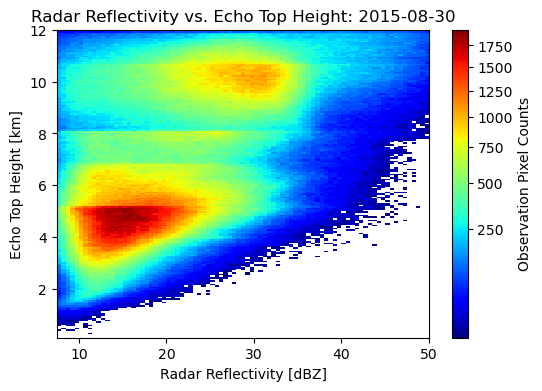

In [101]:
import matplotlib.pyplot as plt
import matplotlib as mpl


fig, ax = plt.subplots(figsize=(6, 4))

# (111, 251)
plt.title(f'Radar Reflectivity vs. Echo Top Height: {date[0:4]}-{date[4:6]}-{date[6:8]}')
plt.hist2d(df_nona.pcp, df_nona.eth, (int((df_nona.pcp.unique().max() - df_nona.pcp.unique().min()) * 2), 251), cmap=plt.cm.jet, norm=mpl.colors.PowerNorm(gamma=0.5), cmin=10)
plt.colorbar(label='Observation Pixel Counts')
ax.set_ylabel('Echo Top Height [km]')
ax.set_xlabel('Radar Reflectivity [dBZ]')
ax.set_xlim((7.5,50))
ax.set_ylim((0.125,12))
# plt.show()

plt.savefig(f'/home/ppavlik/repos/ppavlik-rainguru/analysis_notebooks/pcp_eth_hist2d{date}.pdf', bbox_inches='tight')